# Cascade R-CNN

This notebook details how the Cascade R-CNN model was trained 4-folds, benchmarked and evaluated

install necessary libraries

In [ ]:
from google.colab import drive
import os
import cv2
import os
import json
import torch
import random
import supervision as sv
import numpy as np
import shutil
from google.colab import runtime

installing versions of pytorch and libraries compatible with mmdetection

In [ ]:
!pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 torchdata==0.6.1 torchtext==0.15.2 fastapi kaleido python-multipart uvicorn lida torchdata

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 103.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 100.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 84.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 79.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 75.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 107.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

installing supervision compatible with mmdetection

In [ ]:
!pip install -q supervision==0.13.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 2.5 MB/s eta 0:00:00


setting the variable HOME to the current working directory by using the os.getcwd() function from Python's os module for easy reference of home directory

In [ ]:
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


Setting up up the environment for using MMDetection by installing necessary compatible versions of dependencies (mmengine, mmcv, mmdet), cloning the MMDetection repository, and installing it in an editable mode.

In [ ]:
%cd {HOME}

%pip install -U -q openmim



!mim install "mmengine>=0.7.0"
!mim install "mmcv==2.0.0rc4"

!mim install -q "mmdet>=3.0.0rc6,<3.1.0"



!git clone https://github.com/open-mmlab/mmdetection.git


%cd {HOME}/mmdetection

%pip install -e .

/content
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 77.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 34.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.1/953.1 kB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.9/143.9 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 15.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 14.5 MB/s eta 0:00:00
     ━━━━━━

Mount google drive to access data stored.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


downloading pretrained weights for faster training of the model

In [ ]:
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://download.openmmlab.com/mmdetection/v2.0/cascade_rcnn/cascade_rcnn_r101_fpn_1x_coco/cascade_rcnn_r101_fpn_1x_coco_20200317-0b6a2fbf.pth
!ls -lh {HOME}/weights

total 338M
-rw-r--r-- 1 root root 338M Nov  2  2021 cascade_rcnn_r101_fpn_1x_coco_20200317-0b6a2fbf.pth


Setting up a custom configuration file for the model which defines

* Configuration Path: Sets the path for saving the custom configuration.
* Base Model: Inherits from a Faster R-CNN config and customizes it for the specific dataset.
* Dataset and DataLoader: Configures paths, batch sizes, and annotations for training, validation, and testing datasets.
* Model Architecture: Tailors the roi_head for a single-class detection task, adjusting bounding box heads and loss functions.
* Learning Rate Scheduling: Implements a two-stage learning rate scheduler with linear warm-up and cosine annealing.
* Training Pipeline: Defines data augmentation for the second training stage.
* Optimizer: Uses AdamW with specific learning rates and weight decay settings.
* Hooks: Includes early stopping, checkpointing, and logging to monitor and optimize the training process.
* Pretrained Weights: Loads COCO-pretrained weight to initialize the model.
* Training Loop: Uses an epoch-based training loop with validation at each epoch.
* Visualization: Configures visualizers, including TensorBoard, for monitoring.

In [ ]:
#early stopping
CUSTOM_CONFIG_PATH =f"{HOME}/mmdetection/configs/cascade_rcnn/custom_cascade_rcnn.py"

CUSTOM_CONFIG = """
# Inherit and overwrite part of the config based on this config
_base_ = './cascade-rcnn_r50_fpn_1x_coco.py'

data_root = '/content/drive/MyDrive/Combined Dataset3/2024-07-07_5-Fold_Cross-val/split_1/'  # Ensure this points to your dataset root

train_batch_size_per_gpu = 4
train_num_workers = 2

max_epochs = 100
base_lr = 0.00008
stage2_num_epochs = 1

metainfo = {
    'classes': ('invoice', ),  # Replace 'your_class' with the name of your class
    'palette': [
        (220, 20, 60),
    ]
}

train_dataloader = dict(
    batch_size=train_batch_size_per_gpu,
    num_workers=train_num_workers,
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img='train/images/'),
        ann_file='train/images/annotations.json',))

val_dataloader = dict(
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img='val/images/'),
        ann_file='val/images/annotations.json',))

test_dataloader = val_dataloader

val_evaluator = dict(ann_file=data_root + 'val/images/annotations.json')

test_evaluator = val_evaluator

model = dict(
    backbone=dict(
        depth=101,
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet101')),
    roi_head=dict(
        bbox_head=[
            dict(type='Shared2FCBBoxHead', num_classes=1),
            dict(type='Shared2FCBBoxHead', num_classes=1),
            dict(type='Shared2FCBBoxHead', num_classes=1)
        ]
    )
)

# learning rate
param_scheduler = [
    dict(
        type='LinearLR',
        start_factor=1.0e-5,
        by_epoch=False,
        begin=0,
        end=10),
    dict(
        # use cosine lr from 10 to 20 epoch
        type='CosineAnnealingLR',
        eta_min=base_lr * 0.05,
        begin=max_epochs // 2,
        end=max_epochs,
        T_max=max_epochs // 2,
        by_epoch=True,
        convert_to_iter_based=True),
]

train_pipeline_stage2 = [
    dict(type='LoadImageFromFile', backend_args=None),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='YOLOXHSVRandomAug'),
    dict(type='RandomFlip', prob=0.5),
    dict(type='Pad', size=(640, 640), pad_val=dict(img=(114, 114, 114))),
    dict(type='PackDetInputs')
]

# optimizer
optim_wrapper = dict(
    _delete_=True,
    type='OptimWrapper',
    optimizer=dict(type='AdamW', lr=base_lr, weight_decay=0.05),
    paramwise_cfg=dict(
        norm_decay_mult=0, bias_decay_mult=0, bypass_duplicate=True))

default_hooks = dict(
    early_stopping=dict(
        type='EarlyStoppingHook',
        monitor='coco/bbox_mAP',
        patience=10,
        min_delta=0.01),
    checkpoint=dict(
        type='CheckpointHook',
        interval=5,
        save_begin=1,
        max_keep_ckpts=2,
        save_best='auto'),
    logger=dict(type='LoggerHook', interval=5))

custom_hooks = [
    dict(
        type='PipelineSwitchHook',
        switch_epoch=max_epochs - 1,
        switch_pipeline=train_pipeline_stage2)
]

# load COCO pre-trained weight
load_from = '/content/weights/cascade_rcnn_r101_fpn_1x_coco_20200317-0b6a2fbf.pth'

train_cfg = dict(type='EpochBasedTrainLoop', max_epochs=max_epochs, val_interval=1)
visualizer = dict(vis_backends=[dict(type='LocalVisBackend'), dict(type='TensorboardVisBackend')])
"""

writing the custom configuration file to the folder

In [ ]:
with open(CUSTOM_CONFIG_PATH, 'w') as file:
    file.write(CUSTOM_CONFIG)

Running training on the custom configuration file

In [ ]:
%cd {HOME}/mmdetection
!python tools/train.py configs/cascade_rcnn/custom_cascade_rcnn.py

Streaming output truncated to the last 5000 lines.
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_86,code=sm_86
  - CuDNN 8.5
  - Magma 2.6.1
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=11.7, CUDNN_VERSION=8.5.0, CXX_COMPILER=/opt/rh/devtoolset-9/root/usr/bin/c++, CXX_FLAGS= -D_GLIBCXX_USE_CXX11_ABI=0 -fabi

saving training results to a folder

In [ ]:
#saving best run result

# Source and destination paths
source_folder = '/content/mmdetection/work_dirs/custom_cascade_rcnn'
destination_folder = '/content/drive/MyDrive/CascadeR_CNN_runs/kfolds/cascadercnn100epochs-1fold'

# Copy the folder and its contents
shutil.copytree(source_folder, destination_folder)

'/content/drive/MyDrive/CascadeR_CNN_runs/kfolds/cascadercnn100epochs-1fold'

Defining custom configuration file for 2nd fold with checkpoint of the model trained in the previous fold and saving the training result

In [ ]:
#split 2
CUSTOM_CONFIG_PATH =f"{HOME}/mmdetection/configs/cascade_rcnn/custom_cascade_rcnn.py"

CUSTOM_CONFIG = """
# Inherit and overwrite part of the config based on this config
_base_ = './cascade-rcnn_r50_fpn_1x_coco.py'

data_root = '/content/drive/MyDrive/Combined Dataset3/2024-07-07_5-Fold_Cross-val/split_2/'  # Ensure this points to your dataset root

train_batch_size_per_gpu = 4
train_num_workers = 2

max_epochs = 100
base_lr = 0.00008
stage2_num_epochs = 1

metainfo = {
    'classes': ('invoice', ),  # Replace 'your_class' with the name of your class
    'palette': [
        (220, 20, 60),
    ]
}

train_dataloader = dict(
    batch_size=train_batch_size_per_gpu,
    num_workers=train_num_workers,
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img='train/images/'),
        ann_file='train/images/annotations.json',))

val_dataloader = dict(
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img='val/images/'),
        ann_file='val/images/annotations.json',))

test_dataloader = val_dataloader

val_evaluator = dict(ann_file=data_root + 'val/images/annotations.json')

test_evaluator = val_evaluator

model = dict(
    backbone=dict(
        depth=101,
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet101')),
    roi_head=dict(
        bbox_head=[
            dict(type='Shared2FCBBoxHead', num_classes=1),
            dict(type='Shared2FCBBoxHead', num_classes=1),
            dict(type='Shared2FCBBoxHead', num_classes=1)
        ]
    )
)

# learning rate
param_scheduler = [
    dict(
        type='LinearLR',
        start_factor=1.0e-5,
        by_epoch=False,
        begin=0,
        end=10),
    dict(
        # use cosine lr from 10 to 20 epoch
        type='CosineAnnealingLR',
        eta_min=base_lr * 0.05,
        begin=max_epochs // 2,
        end=max_epochs,
        T_max=max_epochs // 2,
        by_epoch=True,
        convert_to_iter_based=True),
]

train_pipeline_stage2 = [
    dict(type='LoadImageFromFile', backend_args=None),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='YOLOXHSVRandomAug'),
    dict(type='RandomFlip', prob=0.5),
    dict(type='Pad', size=(640, 640), pad_val=dict(img=(114, 114, 114))),
    dict(type='PackDetInputs')
]

# optimizer
optim_wrapper = dict(
    _delete_=True,
    type='OptimWrapper',
    optimizer=dict(type='AdamW', lr=base_lr, weight_decay=0.05),
    paramwise_cfg=dict(
        norm_decay_mult=0, bias_decay_mult=0, bypass_duplicate=True))

default_hooks = dict(
    early_stopping=dict(
        type='EarlyStoppingHook',
        monitor='coco/bbox_mAP',
        patience=10,
        min_delta=0.01),
    checkpoint=dict(
        type='CheckpointHook',
        interval=5,
        save_begin=1,
        max_keep_ckpts=2,
        save_best='auto'),
    logger=dict(type='LoggerHook', interval=5))

custom_hooks = [
    dict(
        type='PipelineSwitchHook',
        switch_epoch=max_epochs - 1,
        switch_pipeline=train_pipeline_stage2)
]

# load COCO pre-trained weight
load_from = '/content/drive/MyDrive/CascadeR_CNN_runs/kfolds/cascadercnn100epochs-1fold/epoch_21.pth'

train_cfg = dict(type='EpochBasedTrainLoop', max_epochs=max_epochs, val_interval=1)
visualizer = dict(vis_backends=[dict(type='LocalVisBackend'), dict(type='TensorboardVisBackend')])
"""

In [ ]:
with open(CUSTOM_CONFIG_PATH, 'w') as file:
    file.write(CUSTOM_CONFIG)

In [ ]:
%cd {HOME}/mmdetection
!python tools/train.py configs/cascade_rcnn/custom_cascade_rcnn.py

/content/mmdetection
07/10 13:11:24 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1444575611
    GPU 0: NVIDIA L4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.2, V12.2.140
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.0.1+cu117
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;a

In [ ]:
#saving best run result
# Source and destination paths
source_folder = '/content/mmdetection/work_dirs/custom_cascade_rcnn'
destination_folder = '/content/drive/MyDrive/CascadeR_CNN_runs/kfolds/cascadercnn100epochs-2fold'

# Copy the folder and its contents
shutil.copytree(source_folder, destination_folder)

'/content/drive/MyDrive/CascadeR_CNN_runs/kfolds/cascadercnn100epochs-2fold'

Defining custom configuration file for 3rd fold with checkpoint of the model trained in the previous fold and saving the training result

In [ ]:
#split 3
CUSTOM_CONFIG_PATH =f"{HOME}/mmdetection/configs/cascade_rcnn/custom_cascade_rcnn.py"

CUSTOM_CONFIG = """
# Inherit and overwrite part of the config based on this config
_base_ = './cascade-rcnn_r50_fpn_1x_coco.py'

data_root = '/content/drive/MyDrive/Combined Dataset3/2024-07-07_5-Fold_Cross-val/split_3/'  # Ensure this points to your dataset root

train_batch_size_per_gpu = 4
train_num_workers = 2

max_epochs = 100
base_lr = 0.00008
stage2_num_epochs = 1

metainfo = {
    'classes': ('invoice', ),  # Replace 'your_class' with the name of your class
    'palette': [
        (220, 20, 60),
    ]
}

train_dataloader = dict(
    batch_size=train_batch_size_per_gpu,
    num_workers=train_num_workers,
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img='train/images/'),
        ann_file='train/images/annotations.json',))

val_dataloader = dict(
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img='val/images/'),
        ann_file='val/images/annotations.json',))

test_dataloader = val_dataloader

val_evaluator = dict(ann_file=data_root + 'val/images/annotations.json')

test_evaluator = val_evaluator

model = dict(
    backbone=dict(
        depth=101,
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet101')),
    roi_head=dict(
        bbox_head=[
            dict(type='Shared2FCBBoxHead', num_classes=1),
            dict(type='Shared2FCBBoxHead', num_classes=1),
            dict(type='Shared2FCBBoxHead', num_classes=1)
        ]
    )
)

# learning rate
param_scheduler = [
    dict(
        type='LinearLR',
        start_factor=1.0e-5,
        by_epoch=False,
        begin=0,
        end=10),
    dict(
        # use cosine lr from 10 to 20 epoch
        type='CosineAnnealingLR',
        eta_min=base_lr * 0.05,
        begin=max_epochs // 2,
        end=max_epochs,
        T_max=max_epochs // 2,
        by_epoch=True,
        convert_to_iter_based=True),
]

train_pipeline_stage2 = [
    dict(type='LoadImageFromFile', backend_args=None),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='YOLOXHSVRandomAug'),
    dict(type='RandomFlip', prob=0.5),
    dict(type='Pad', size=(640, 640), pad_val=dict(img=(114, 114, 114))),
    dict(type='PackDetInputs')
]

# optimizer
optim_wrapper = dict(
    _delete_=True,
    type='OptimWrapper',
    optimizer=dict(type='AdamW', lr=base_lr, weight_decay=0.05),
    paramwise_cfg=dict(
        norm_decay_mult=0, bias_decay_mult=0, bypass_duplicate=True))

default_hooks = dict(
    early_stopping=dict(
        type='EarlyStoppingHook',
        monitor='coco/bbox_mAP',
        patience=10,
        min_delta=0.01),
    checkpoint=dict(
        type='CheckpointHook',
        interval=5,
        save_begin=1,
        max_keep_ckpts=2,
        save_best='auto'),
    logger=dict(type='LoggerHook', interval=5))

custom_hooks = [
    dict(
        type='PipelineSwitchHook',
        switch_epoch=max_epochs - 1,
        switch_pipeline=train_pipeline_stage2)
]

# load COCO pre-trained weight
load_from = '/content/drive/MyDrive/CascadeR_CNN_runs/kfolds/cascadercnn100epochs-2fold/epoch_11.pth'

train_cfg = dict(type='EpochBasedTrainLoop', max_epochs=max_epochs, val_interval=1)
visualizer = dict(vis_backends=[dict(type='LocalVisBackend'), dict(type='TensorboardVisBackend')])
"""

In [ ]:
with open(CUSTOM_CONFIG_PATH, 'w') as file:
    file.write(CUSTOM_CONFIG)

In [ ]:
%cd {HOME}/mmdetection
!python tools/train.py configs/cascade_rcnn/custom_cascade_rcnn.py

/content/mmdetection
07/10 15:48:37 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 760584298
    GPU 0: NVIDIA L4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.2, V12.2.140
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.0.1+cu117
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;ar

In [ ]:
#saving best run result
# Source and destination paths
source_folder = '/content/mmdetection/work_dirs/custom_cascade_rcnn'
destination_folder = '/content/drive/MyDrive/CascadeR_CNN_runs/kfolds/cascadercnn100epochs-3fold'

# Copy the folder and its contents
shutil.copytree(source_folder, destination_folder)

'/content/drive/MyDrive/CascadeR_CNN_runs/kfolds/cascadercnn100epochs-3fold'

Defining a custom configuration file for the 4th fold, incorporating rotation augmentation to improve performance on detecting rotated images, using the checkpoint from the model trained in the previous fold, and saving the training results.

In [ ]:
#rotations
CUSTOM_CONFIG_PATH =f"{HOME}/mmdetection/configs/cascade_rcnn/custom_cascade_rcnn.py"

CUSTOM_CONFIG = """
# Inherit and overwrite part of the config based on this config
_base_ = './cascade-rcnn_r50_fpn_1x_coco.py'

data_root = '/content/drive/MyDrive/Combined Dataset3/2024-07-07_5-Fold_Cross-val/split_4/'  # Ensure this points to your dataset root

train_batch_size_per_gpu = 4
train_num_workers = 2

max_epochs = 100
base_lr = 0.00008
stage2_num_epochs = 1

metainfo = {
    'classes': ('invoice', ),  # Replace 'your_class' with the name of your class
    'palette': [
        (220, 20, 60),
    ]
}

train_dataloader = dict(
    batch_size=train_batch_size_per_gpu,
    num_workers=train_num_workers,
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img='train/images/'),
        ann_file='train/images/annotations.json',))

val_dataloader = dict(
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img='val/images/'),
        ann_file='val/images/annotations.json',))

test_dataloader = val_dataloader

val_evaluator = dict(ann_file=data_root + 'val/images/annotations.json')

test_evaluator = val_evaluator

model = dict(
    backbone=dict(
        depth=101,
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet101')),
    roi_head=dict(
        bbox_head=[
            dict(type='Shared2FCBBoxHead', num_classes=1),
            dict(type='Shared2FCBBoxHead', num_classes=1),
            dict(type='Shared2FCBBoxHead', num_classes=1)
        ]
    )
)

# learning rate
param_scheduler = [
    dict(
        type='LinearLR',
        start_factor=1.0e-5,
        by_epoch=False,
        begin=0,
        end=10),
    dict(
        # use cosine lr from 10 to 20 epoch
        type='CosineAnnealingLR',
        eta_min=base_lr * 0.05,
        begin=max_epochs // 2,
        end=max_epochs,
        T_max=max_epochs // 2,
        by_epoch=True,
        convert_to_iter_based=True),
]

train_pipeline = [
    dict(type='LoadImageFromFile', backend_args=None),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='RandomRotate', angle_range=(-100, 100), prob=0.5),  # Adding random rotation
    dict(type='YOLOXHSVRandomAug'),
    dict(type='RandomFlip', prob=0.5),
    dict(type='Pad', size=(640, 640), pad_val=dict(img=(114, 114, 114))),
    dict(type='PackDetInputs')
]

train_pipeline_stage2 = [
    dict(type='LoadImageFromFile', backend_args=None),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='RandomRotate', angle_range=(-10, 10), prob=0.5),  # Adding random rotation
    dict(type='YOLOXHSVRandomAug'),
    dict(type='RandomFlip', prob=0.5),
    dict(type='Pad', size=(640, 640), pad_val=dict(img=(114, 114, 114))),
    dict(type='PackDetInputs')
]

# optimizer
optim_wrapper = dict(
    _delete_=True,
    type='OptimWrapper',
    optimizer=dict(type='AdamW', lr=base_lr, weight_decay=0.05),
    paramwise_cfg=dict(
        norm_decay_mult=0, bias_decay_mult=0, bypass_duplicate=True))

default_hooks = dict(
    early_stopping=dict(
        type='EarlyStoppingHook',
        monitor='coco/bbox_mAP',
        patience=10,
        min_delta=0.01),
    checkpoint=dict(
        type='CheckpointHook',
        interval=5,
        save_begin=1,
        max_keep_ckpts=2,
        save_best='auto'),
    logger=dict(type='LoggerHook', interval=5))

custom_hooks = [
    dict(
        type='PipelineSwitchHook',
        switch_epoch=max_epochs - 1,
        switch_pipeline=train_pipeline_stage2)
]

# load COCO pre-trained weight
load_from = '/content/drive/MyDrive/CascadeR_CNN_runs/kfolds/cascadercnn100epochs-3fold/epoch_11.pth'

train_cfg = dict(type='EpochBasedTrainLoop', max_epochs=max_epochs, val_interval=1)
visualizer = dict(vis_backends=[dict(type='LocalVisBackend'), dict(type='TensorboardVisBackend')])
"""

In [ ]:
with open(CUSTOM_CONFIG_PATH, 'w') as file:
    file.write(CUSTOM_CONFIG)

In [ ]:
%cd {HOME}/mmdetection
!python tools/train.py configs/cascade_rcnn/custom_cascade_rcnn.py

/content/mmdetection
07/15 12:54:49 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Mar 22 2024, 16:50:05) [GCC 11.4.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1259253597
    GPU 0: NVIDIA L4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.2, V12.2.140
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.0.1+cu117
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;a

In [ ]:
#saving best run result
import shutil

# Source and destination paths
source_folder = '/content/mmdetection/work_dirs/custom_cascade_rcnn'
destination_folder = '/content/drive/MyDrive/CascadeR_CNN_runs/kfolds/cascadercnn100epochs-4fold-2'

# Copy the folder and its contents
shutil.copytree(source_folder, destination_folder)

Command to disconnect runtime after training

In [ ]:
runtime.unassign()

# Bench Marking

Code to calculate memory usage of the model

In [ ]:
!python tools/analysis_tools/benchmark.py configs/cascade_rcnn/custom_cascade_rcnn.py --checkpoint /content/drive/MyDrive/CascadeR_CNN_runs/kfolds/cascadercnn100epochs-4fold-2/epoch_8.pth --dataset-type val --fuse-conv-bn

/content/mmdetection
07/15 17:10:26 - mmengine - INFO - before build: 
07/15 17:10:26 - mmengine - INFO - (GB) mem_used: 1.74 | uss: 0.32 | pss: 0.40 | total_proc: 1
loading annotations into memory...
Done (t=5.13s)
creating index...
index created!
07/15 17:10:33 - mmengine - INFO - after build: 
07/15 17:10:33 - mmengine - INFO - (GB) mem_used: 1.79 | uss: 0.37 | pss: 0.46 | total_proc: 1
07/15 17:10:56 - mmengine - INFO - ==================================
07/15 17:10:56 - mmengine - INFO - Done batch [50 /2000], fps: 2.2 batch/s, times per batch: 446.0 ms/batch, batch size: 1, num_workers: 2
07/15 17:10:56 - mmengine - INFO - (GB) mem_used: 1.87 | uss: 0.12 | pss: 0.52 | total_proc: 3
07/15 17:11:19 - mmengine - INFO - ==================================
07/15 17:11:19 - mmengine - INFO - Done batch [100/2000], fps: 2.2 batch/s, times per batch: 455.7 ms/batch, batch size: 1, num_workers: 2
07/15 17:11:19 - mmengine - INFO - (GB) mem_used: 1.90 | uss: 0.17 | pss: 0.57 | total_proc: 3

# Evaluation

Code to calculate performance metrics like recall, mAP50, mAP75 and mAP50-95

In [ ]:
!python tools/test.py configs/cascade_rcnn/custom_cascade_rcnn.py '/content/drive/MyDrive/CascadeR_CNN_runs/kfolds/cascadercnn100epochs-4fold-2/epoch_8.pth' --out results.pkl

/content/mmdetection
07/15 18:54:32 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Mar 22 2024, 16:50:05) [GCC 11.4.0]
    CUDA available: False
    MUSA available: False
    numpy_random_seed: 1895217911
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.0.1+cu117
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=11.7, CUDNN_VERSION=8.5.0, CXX_COMPILER=/opt/rh/devtoolset-9/root/usr/bin/c++, CXX_FLAGS= -D_GLIBCXX_U

---
# Experimentation Codes

This section contains pieces of code used for testing or experimenting

 Without K-Fold

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [ ]:
!pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 torchdata==0.6.1 torchtext==0.15.2 fastapi kaleido python-multipart uvicorn lida torchdata

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 677.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
%cd {HOME}

%pip install -U -q openmim


!mim install -q "mmdet>=3.0.0rc6,<3.1.0"


!mim install "mmengine>=0.7.0"
!mim install "mmcv>=2.0.0rc4"


!git clone https://github.com/open-mmlab/mmdetection.git


%cd {HOME}/mmdetection

%pip install -e .

In [ ]:
!pip install -q supervision==0.13.0

In [ ]:
import cv2
import os
import json
import torch
import random
import supervision as sv
import numpy as np

In [ ]:
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://download.openmmlab.com/mmdetection/v2.0/cascade_rcnn/cascade_rcnn_r101_fpn_1x_coco/cascade_rcnn_r101_fpn_1x_coco_20200317-0b6a2fbf.pth
!ls -lh {HOME}/weights

total 338M
-rw-r--r-- 1 root root 338M Nov  2  2021 cascade_rcnn_r101_fpn_1x_coco_20200317-0b6a2fbf.pth


In [ ]:
BATCH_SIZE = 8
MAX_EPOCHS = 50

In [ ]:
#early stopping
CUSTOM_CONFIG_PATH =f"{HOME}/mmdetection/configs/cascade_rcnn/custom_cascade_rcnn.py"

CUSTOM_CONFIG = """
# Inherit and overwrite part of the config based on this config
_base_ = './cascade-rcnn_r50_fpn_1x_coco.py'

data_root = '/content/drive/MyDrive/Combined Dataset2/'  # Ensure this points to your dataset root

train_batch_size_per_gpu = 4
train_num_workers = 2

max_epochs = 200
base_lr = 0.00008
stage2_num_epochs = 1

metainfo = {
    'classes': ('invoice', ),  # Replace 'your_class' with the name of your class
    'palette': [
        (220, 20, 60),
    ]
}

train_dataloader = dict(
    batch_size=train_batch_size_per_gpu,
    num_workers=train_num_workers,
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img='train/images/'),
        ann_file='train/images/annotations.json',))

val_dataloader = dict(
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img='valid/images/'),
        ann_file='valid/images/annotations.json',))

test_dataloader = dict(
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img='test/images/'),
        ann_file='test/images/annotations.json',))

val_evaluator = dict(ann_file=data_root + 'valid/images/annotations.json')

test_evaluator = dict(ann_file=data_root + 'test/images/annotations.json')

model = dict(
    backbone=dict(
        depth=101,
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet101')),
    roi_head=dict(
        bbox_head=[
            dict(type='Shared2FCBBoxHead', num_classes=1),
            dict(type='Shared2FCBBoxHead', num_classes=1),
            dict(type='Shared2FCBBoxHead', num_classes=1)
        ]
    )
)

# learning rate
param_scheduler = [
    dict(
        type='LinearLR',
        start_factor=1.0e-5,
        by_epoch=False,
        begin=0,
        end=10),
    dict(
        # use cosine lr from 10 to 20 epoch
        type='CosineAnnealingLR',
        eta_min=base_lr * 0.05,
        begin=max_epochs // 2,
        end=max_epochs,
        T_max=max_epochs // 2,
        by_epoch=True,
        convert_to_iter_based=True),
]

train_pipeline_stage2 = [
    dict(type='LoadImageFromFile', backend_args=None),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='YOLOXHSVRandomAug'),
    dict(type='RandomFlip', prob=0.5),
    dict(type='Pad', size=(640, 640), pad_val=dict(img=(114, 114, 114))),
    dict(type='PackDetInputs')
]

# optimizer
optim_wrapper = dict(
    _delete_=True,
    type='OptimWrapper',
    optimizer=dict(type='AdamW', lr=base_lr, weight_decay=0.05),
    paramwise_cfg=dict(
        norm_decay_mult=0, bias_decay_mult=0, bypass_duplicate=True))

default_hooks = dict(
    early_stopping=dict(
        type='EarlyStoppingHook',
        monitor='coco/bbox_mAP',
        patience=10,
        min_delta=0.01),
    checkpoint=dict(
        type='CheckpointHook',
        interval=5,
        save_begin=1,
        max_keep_ckpts=2,
        save_best='auto'),
    logger=dict(type='LoggerHook', interval=5))

custom_hooks = [
    dict(
        type='PipelineSwitchHook',
        switch_epoch=max_epochs - 1,
        switch_pipeline=train_pipeline_stage2)
]

# load COCO pre-trained weight
load_from = '/content/weights/cascade_rcnn_r101_fpn_1x_coco_20200317-0b6a2fbf.pth'

train_cfg = dict(type='EpochBasedTrainLoop', max_epochs=max_epochs, val_interval=1)
visualizer = dict(vis_backends=[dict(type='LocalVisBackend'), dict(type='TensorboardVisBackend')])
"""

In [ ]:
with open(CUSTOM_CONFIG_PATH, 'w') as file:
    file.write(CUSTOM_CONFIG)

In [ ]:
%cd {HOME}/mmdetection
!python tools/train.py configs/cascade_rcnn/custom_cascade_rcnn.py

/content/mmdetection
06/22 18:58:26 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 2128049547
    GPU 0: NVIDIA L4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.2, V12.2.140
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.0.1+cu117
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;a

In [ ]:
#saving best run result
import shutil

# Source and destination paths
source_folder = '/content/mmdetection/work_dirs/custom_cascade_rcnn'
destination_folder = '/content/drive/MyDrive/CascadeR_CNN_runs/cascadercnn200epochs-best18'

# Copy the folder and its contents
shutil.copytree(source_folder, destination_folder)

'/content/drive/MyDrive/CascadeR_CNN_runs/cascadercnn200epochs-best18'

In [ ]:
CUSTOM_WEIGHTS_PATH = "/content/drive/MyDrive/CascadeR_CNN_runs/cascadercnn200epochs-best18/epoch_17.pth"

In [ ]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
from mmdet.apis import init_detector, inference_detector

In [ ]:
model = init_detector(CUSTOM_CONFIG_PATH, CUSTOM_WEIGHTS_PATH, device=DEVICE)

Loads checkpoint by local backend from path: /content/drive/MyDrive/CascadeR_CNN_runs/cascadercnn200epochs-best18/epoch_17.pth


In [ ]:
evaluation = dict(interval=1, metric=['bbox'], save_best='bbox_mAP_50')

In [ ]:
!python tools/test.py '/content/mmdetection/configs/cascade_rcnn/custom_cascade_rcnn.py' '/content/drive/MyDrive/CascadeR_CNN_runs/cascadercnn200epochs-best18/epoch_17.pth' --out results.pkl

06/26 07:46:59 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
    CUDA available: False
    MUSA available: False
    numpy_random_seed: 2139050457
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.0.1+cu117
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=11.7, CUDNN_VERSION=8.5.0, CXX_COMPILER=/opt/rh/devtoolset-9/root/usr/bin/c++, CXX_FLAGS= -D_GLIBCXX_USE_CXX11_ABI=0 -fabi-

In [ ]:
# Given values
precision = 0.912
recall = 0.883

# Calculate F1 Score
f1_score = 2 * (precision * recall) / (precision + recall)
f1_score


0.89726573816156

In [ ]:
from mmengine.evaluator import Evaluator
from mmengine.fileio import load

# Build the evaluator. The parameter `metrics` is the configuration of the evaluation metric
evaluator = Evaluator(metrics=dict(type='Accuracy', top_k=(1, 5)))

# Reads the test data from a file. The data format needs to refer to the metric used.
data = load('test_data.pkl')

# The model prediction result is read from the file. The result is inferred by the algorithm to be evaluated on the test dataset.
# The data format needs to refer to the metric used.
data_samples = load('prediction.pkl')

# Call the evaluator offline evaluation interface and get the evaluation results
# chunk_size indicates the number of samples processed at a time, which can be adjusted according to the memory size
results = evaluator.offline_evaluate(data, data_samples, chunk_size=128)

In [ ]:
import pickle
from mmdet.apis import init_detector
from mmcv import Config
from mmdet.datasets import build_dataset
#from mmdet.core.evaluation import eval_map, eval_recalls

# Load the results from the file
results_file = '/content/mmdetection/results.pkl'
with open(results_file, 'rb') as f:
    results = pickle.load(f)

# Load the configuration file
config_file = CUSTOM_CONFIG_PATH  # You need to specify the correct path
cfg = Config.fromfile(config_file)

# Modify config for evaluation
cfg.data.test.test_mode = True

# Build the dataset
dataset = build_dataset(cfg.data.test)

# Evaluate the results
eval_results = dataset.evaluate(results, metric='bbox')
print(eval_results)

# Calculate additional metrics
# Assuming eval_results contains mAP at different IoU thresholds

# Precision and Recall are not directly available, so we'll use mAP values as proxies
mAP50 = eval_results['bbox_mAP_50']
mAP5095 = eval_results['bbox_mAP']

# Typically, precision and recall would require additional computations, but for simplicity:
precision = mAP50
recall = mAP50

f1_score = 2 * (precision * recall) / (precision + recall)

print(f'mAP50: {mAP50}')
print(f'mAP50-95: {mAP5095}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')


ImportError: cannot import name 'Config' from 'mmcv' (/usr/local/lib/python3.10/dist-packages/mmcv/__init__.py)

In [ ]:
ds = sv.DetectionDataset.from_coco(
    images_directory_path="/content/drive/MyDrive/Combined Dataset2/valid/images/",
    annotations_path="/content/drive/MyDrive/Combined Dataset2/valid/images/annotations.json",
)

print('dataset classes:', ds.classes)
print('dataset size:', len(ds))

dataset classes: ['invoice']
dataset size: 293


In [ ]:
CONFIDENCE_THRESHOLD = 0.35
NMS_IOU_THRESHOLD = 0.7

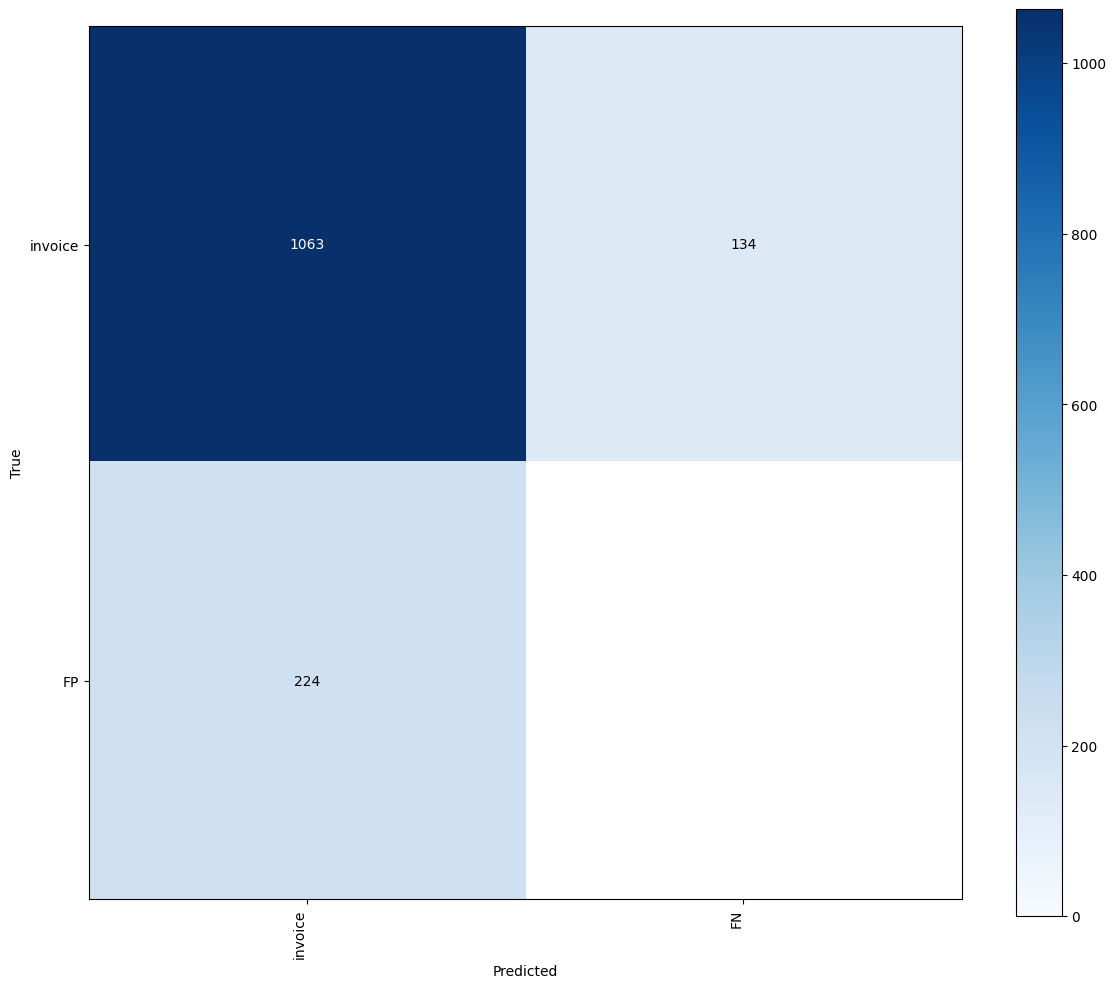

In [ ]:
def callback(image: np.ndarray) -> sv.Detections:
    result = inference_detector(model, image)
    detections = sv.Detections.from_mmdetection(result)
    return detections[detections.confidence > CONFIDENCE_THRESHOLD].with_nms(threshold=NMS_IOU_THRESHOLD)


confusion_matrix = sv.ConfusionMatrix.benchmark(
    dataset = ds,
    callback = callback
)

_ = confusion_matrix.plot()

In [ ]:
mean_average_precision = sv.MeanAveragePrecision.benchmark(
    dataset = ds,
    callback = callback
)

print('mAP:', mean_average_precision.map50_95)

mAP: 0.8866460145667732


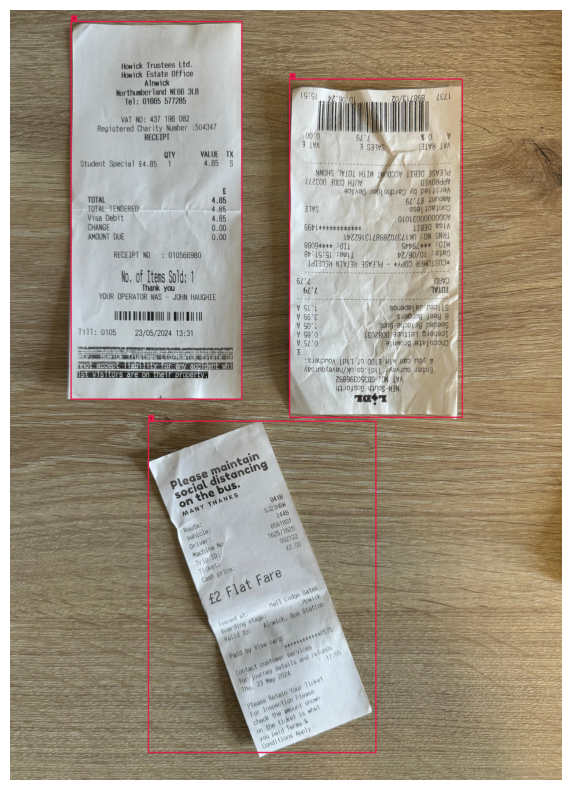

In [ ]:
IMAGE_PATH = "/content/drive/MyDrive/Combined Dataset2/test/images/combined_3.jpg"
image = cv2.imread(IMAGE_PATH)
result = inference_detector(model, image)

detections = sv.Detections.from_mmdetection(result)
box_annotator = sv.BoxAnnotator()
annotated_image = box_annotator.annotate(image.copy(), detections)
sv.plot_image(image=annotated_image, size=(10, 10))

In [ ]:
detections = detections[detections.confidence > 0.3].with_nms()
box_annotator = sv.BoxAnnotator()
annotated_image = box_annotator.annotate(image.copy(), detections)
sv.plot_image(image=annotated_image, size=(10, 10))